In [1]:
import torch
import torch.utils.data
import glob
import random
import numpy as np
import pandas as pd
from torch import nn, optim
from torch.nn import functional as F
import time
from torch.nn.utils import weight_norm

C:\Users\masg\Anaconda3\envs\hls4ml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 1995
random.seed(seed)     # python random generator
np.random.seed(seed)  # numpy random generator

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
Fs = 100000

In [4]:
train_data_torch = torch.load('../data/databases/train_data_torch_main.pt')
train_targets_torch = torch.load('../data/databases/train_targets_torch_main.pt')

test_data_torch = torch.load('../data/databases/valid_data_torch_main.pt')
test_targets_torch = torch.load('../data/databases/valid_targets_torch_main.pt')

In [5]:
torch.sum(train_targets_torch==0)

tensor(7443)

In [6]:
torch.sum(train_targets_torch==1)

tensor(4048)

In [7]:
torch.sum(train_targets_torch==2)

tensor(4848)

In [8]:
print('Dim Train Data: ', train_data_torch.shape)
print('Dim Train Targets: ', train_targets_torch.shape)
print('Dim Test Data: ', test_data_torch.shape)
print('Dim Train Targets: ', test_targets_torch.shape)

Dim Train Data:  torch.Size([16339, 1, 35000])
Dim Train Targets:  torch.Size([16339])
Dim Test Data:  torch.Size([256, 1, 35000])
Dim Train Targets:  torch.Size([256])


In [9]:
numChannels = 1
numClasses = 3

In [10]:
import matplotlib.pyplot as plt
i = 100

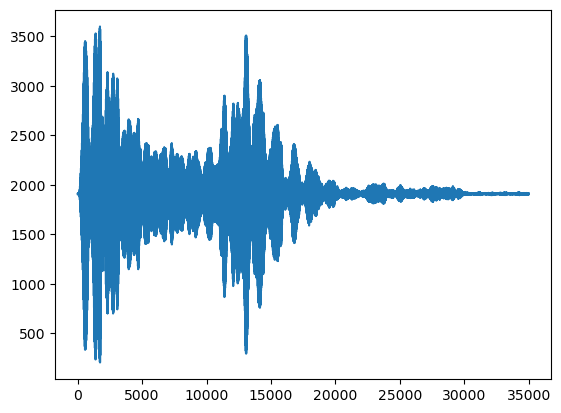

In [11]:
plt.plot(train_data_torch.narrow(0, i, 1).narrow(1, 0, 1).view(-1).numpy())

# This is the formula for computing the size of the output of every layer

$$L_{out} = \frac{L_{in}- Kernel_{size}}{stride}+1$$

# Here there's and example: 
$input size = 1 * 20'000 * 4 $

after the first convolution:
$output = \frac{20000-5000}{5}+1 = 3001$
and the channels go from the initial 4 to the specified 32

after the second convolution:
$output = \frac{3001-2002}{1}+1 = 1000$
and the channels go from 32 to 64

after the last convolution:
$output = \frac{1000-1000}{1}+1 = 1$
and the channels go from 64 to 5 (as the number of classes!!!)




In [12]:
(35000-5000)/2+1

15001.0

In [13]:
(15001-5000)/2+1

5001.5

In [14]:
(5001-4500)/2+1

251.5

In [15]:
KERNEL_SIZE = 128
POOL_FACT = 2
STRIDE_FACT = KERNEL_SIZE // 4
CHANNEL_COUNT = 32
use_avg_pool = True
model = torch.nn.Sequential() 
output_dim = 35000
model.append(torch.nn.Conv1d(in_channels = 1, out_channels = CHANNEL_COUNT, kernel_size = KERNEL_SIZE, stride=STRIDE_FACT)) #16x16896 - 512 + 1 
output_dim = (output_dim - KERNEL_SIZE) // STRIDE_FACT + 1
model.append(torch.nn.ReLU()) 
if use_avg_pool:
    model.append(torch.nn.AvgPool1d(POOL_FACT))
else:
    model.append(torch.nn.MaxPool1d(POOL_FACT)) #16x8192
output_dim /= POOL_FACT
model.append(torch.nn.Conv1d(in_channels = CHANNEL_COUNT, out_channels=CHANNEL_COUNT, kernel_size=KERNEL_SIZE // 2, stride=STRIDE_FACT // 2)) #16x7681
output_dim = (output_dim - KERNEL_SIZE // 2) // (STRIDE_FACT // 2)+ 1
model.append(torch.nn.ReLU())
if use_avg_pool:
    model.append(torch.nn.AvgPool1d(POOL_FACT))
else:
    model.append(torch.nn.MaxPool1d(POOL_FACT)) #16x8192
output_dim /= POOL_FACT
model.append(torch.nn.Flatten())
model.append(torch.nn.Linear(in_features = int(output_dim) * CHANNEL_COUNT, out_features = 9))
model.append(torch.nn.ReLU())
model.append(torch.nn.Linear(in_features = 9, out_features = 3))

Sequential(
  (0): Conv1d(1, 32, kernel_size=(128,), stride=(32,))
  (1): ReLU()
  (2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (3): Conv1d(32, 32, kernel_size=(64,), stride=(16,))
  (4): ReLU()
  (5): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=480, out_features=9, bias=True)
  (8): ReLU()
  (9): Linear(in_features=9, out_features=3, bias=True)
)

In [16]:
#model, criterion = fastCNN(), nn.CrossEntropyLoss()

In [17]:
criterion = torch.nn.CrossEntropyLoss()

In [18]:
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [19]:
count_parameters(model)

74055

In [20]:
def compute_nb_errors(model, testing_generator):
    nb_errors=0
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in testing_generator:
            if (torch.cuda.is_available()):
                # Transfer to GPU
                local_batch, local_labels = local_batch.cuda(), local_labels.cuda()
            outputTest = model(local_batch)
            predicted_classes = outputTest.max(1)[1]
            nb_errors += (predicted_classes != local_labels).long().sum()

    return nb_errors

In [21]:
if (torch.cuda.is_available()):
    model = model.cuda()

In [22]:
train_input = train_data_torch.view(train_data_torch.size(0), numChannels, -1).float()
train_target = train_targets_torch.long().view(-1)
test_input = test_data_torch.view(test_data_torch.size(0), numChannels, -1).float()
test_target = test_targets_torch.long().view(-1)

In [23]:
train_input.shape

torch.Size([16339, 1, 35000])

In [24]:
train_input = (train_input-torch.mean(train_input,2,keepdim=True))
test_input = (test_input-torch.mean(test_input,2,keepdim=True))

In [25]:
train_input = train_input/torch.max(train_input,2,keepdim=True)[0]
test_input = test_input/torch.max(test_input,2,keepdim=True)[0]

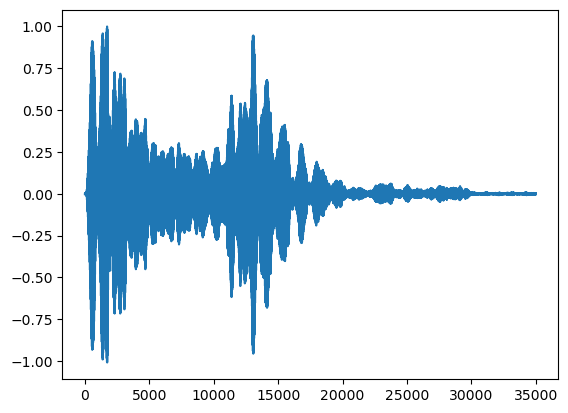

In [26]:
plt.plot(train_input.narrow(0, i, 1).narrow(1, 0, 1).view(-1).numpy())

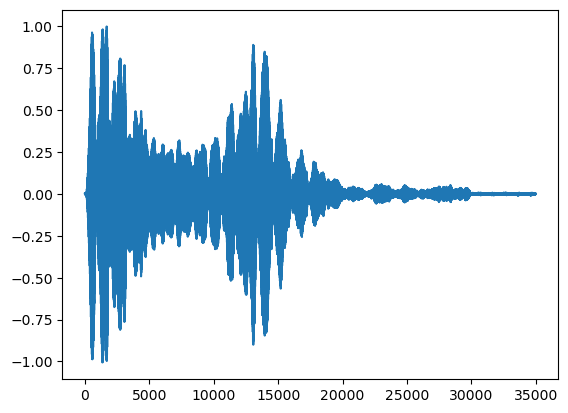

In [27]:
plt.plot(test_input.narrow(0, i, 1).narrow(1, 0, 1).view(-1).numpy())

In [28]:
train_input.narrow(0, 0, 2).shape

torch.Size([2, 1, 35000])

In [29]:
out = model(train_input.narrow(0, 0, 2))
out.shape

torch.Size([2, 3])

In [30]:
lr = 3e-3

In [31]:
optimizer = optim.Adam(model.parameters(), lr = lr)
nb_epochs = 150
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, factor=0.2, patience = 30)

In [32]:
class errorsTable():
    def __init__(self):
        self.accuracyMatr = np.zeros((numClasses,numClasses))
    def newEntry(self,predictions,groundTruths):
        for pred,tru in zip(predictions,groundTruths):
            #print(pred, tru)
            self.accuracyMatr[pred,tru]+=1
    def getStats(self):
        #print(self.accuracyMatr)
        numEntry = np.sum(self.accuracyMatr,0)
        resultMatr = self.accuracyMatr/numEntry
        return resultMatr

In [33]:
np.set_printoptions(precision=2, suppress=True)

In [34]:
batch_size_train = 32
batch_size_test = 1000

In [35]:
#torch.backends.cudnn.enabled = False

In [36]:
training_set = torch.utils.data.TensorDataset(train_input, train_target)
testing_set = torch.utils.data.TensorDataset(test_input, test_target)

In [37]:
# Generators
training_generator = torch.utils.data.DataLoader(training_set, batch_size=batch_size_train, num_workers=0,
                                                shuffle=True, drop_last=True)
testing_generator = torch.utils.data.DataLoader(testing_set, batch_size=batch_size_test, num_workers=0,
                                                 shuffle=False, drop_last=False)

In [38]:
loss_train = []
loss_test = []

t = time.time()
for k in range (nb_epochs):
    
    # Create a new error table
    accuracyTRAIN = errorsTable()
    accuracyTEST = errorsTable()
    print('Epoch: ', k)
    model.train()

    lossValue = 0
    for local_batch, local_labels in training_generator:
        if (torch.cuda.is_available()):
            # Transfer to GPU
            local_batch, local_labels = local_batch.cuda(), local_labels.cuda()       
        model.zero_grad()
        output = model(local_batch)
        accuracyTRAIN.newEntry(output.max(1)[1], local_labels)
        loss = criterion(output, local_labels)
        lossValue += loss.item()*local_batch.size(0)
        loss.backward()
        optimizer.step()
    scheduler.step(lossValue/train_input.size(0))
    print('Loss is ', lossValue/train_input.size(0))
    loss_train.append(lossValue/train_input.size(0))    
    ################################################################    
    model.eval()
    lossValue = 0 
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in testing_generator:
            if (torch.cuda.is_available()):
                # Transfer to GPU
                local_batch, local_labels = local_batch.cuda(), local_labels.cuda()
            outputTest = model(local_batch)
            accuracyTEST.newEntry(outputTest.max(1)[1], local_labels)
            lossTest = criterion(outputTest, local_labels)
            lossValue += lossTest.item()*local_batch.size(0)
    print('Loss TEST is ', lossValue/test_input.size(0))
    loss_test.append(lossValue/test_input.size(0))
    print("")
    print("The accuracy in TEST is: ")
    print("  1      2      3   ")
    print(accuracyTEST.getStats())
    print("The accuracy in TRAIN is: ")
    print("  1      2      3   ")
    print(accuracyTRAIN.getStats())
    print("----------------------")
    if k%10 == 0:
        #nb_test_errors = compute_nb_errors(model, test_input, test_target, batch_size_test)

        #print(k, ': Test accuracy Net {:0.2f}%% {:d}/{:d}'.format(100-(100 * nb_test_errors) / test_input.size(0),
                                                     #nb_test_errors, test_input.size(0)))
        

        #nb_train_errors = compute_nb_errors(model, train_input, train_target, batch_size_train)

        #print(k, ': Train accuracy Net {:0.2f}%% {:d}/{:d}'.format(100-(100 * nb_train_errors) / train_input.size(0),
                                                          #nb_train_errors, train_input.size(0)))
        print("Hey! Ten epochs are passed! We are getting older")
        
        


nb_test_errors = compute_nb_errors(model, testing_generator)  
print('Final Test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                  nb_test_errors, test_input.size(0)))

elapsed = time.time() - t
print(elapsed)

Epoch:  0
Loss is  0.4646982942233654
Loss TEST is  0.5106850862503052

The accuracy in TEST is: 
  1      2      3   
[[0. 0. 0.]
 [1. 1. 0.]
 [0. 0. 1.]]
The accuracy in TRAIN is: 
  1      2      3   
[[0.77 0.1  0.14]
 [0.07 0.86 0.04]
 [0.16 0.05 0.82]]
----------------------
Hey! Ten epochs are passed! We are getting older
Epoch:  1
Loss is  0.1940380383153624
Loss TEST is  0.507250964641571

The accuracy in TEST is: 
  1      2      3   
[[0. 0. 0.]
 [1. 1. 0.]
 [0. 0. 1.]]
The accuracy in TRAIN is: 
  1      2      3   
[[0.85 0.01 0.01]
 [0.02 0.99 0.01]
 [0.12 0.   0.98]]
----------------------
Epoch:  2
Loss is  0.14792770970312033
Loss TEST is  0.5357583165168762

The accuracy in TEST is: 
  1      2      3   
[[0. 0. 0.]
 [1. 1. 0.]
 [0. 0. 1.]]
The accuracy in TRAIN is: 
  1      2      3   
[[0.94 0.01 0.01]
 [0.03 0.99 0.01]
 [0.03 0.   0.98]]
----------------------
Epoch:  3
Loss is  0.09535519896467631
Loss TEST is  0.5645617842674255

The accuracy in TEST is: 
  1   

Loss is  0.018043305907943154
Loss TEST is  0.8903508186340332

The accuracy in TEST is: 
  1      2      3   
[[0. 0. 0.]
 [1. 1. 0.]
 [0. 0. 1.]]
The accuracy in TRAIN is: 
  1      2      3   
[[0.99 0.   0.  ]
 [0.01 1.   0.  ]
 [0.   0.   1.  ]]
----------------------
Epoch:  30
Loss is  0.02163691631908127
Loss TEST is  0.827877938747406

The accuracy in TEST is: 
  1      2      3   
[[0. 0. 0.]
 [1. 1. 0.]
 [0. 0. 1.]]
The accuracy in TRAIN is: 
  1      2      3   
[[0.99 0.   0.  ]
 [0.01 1.   0.  ]
 [0.   0.   1.  ]]
----------------------
Hey! Ten epochs are passed! We are getting older
Epoch:  31
Loss is  0.00999714714839067
Loss TEST is  0.6969941258430481

The accuracy in TEST is: 
  1      2      3   
[[0. 0. 0.]
 [1. 1. 0.]
 [0. 0. 1.]]
The accuracy in TRAIN is: 
  1      2      3   
[[0.99 0.   0.  ]
 [0.01 1.   0.  ]
 [0.   0.   1.  ]]
----------------------
Epoch:  32
Loss is  0.007887487896140617
Loss TEST is  0.5607114434242249

The accuracy in TEST is: 
  1      

Loss is  0.00011517827772785119
Loss TEST is  0.006636633537709713

The accuracy in TEST is: 
  1      2      3   
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
The accuracy in TRAIN is: 
  1      2      3   
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
----------------------
Epoch:  60
Loss is  0.00010228422963398267
Loss TEST is  0.006198849529027939

The accuracy in TEST is: 
  1      2      3   
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
The accuracy in TRAIN is: 
  1      2      3   
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
----------------------
Hey! Ten epochs are passed! We are getting older
Epoch:  61
Loss is  9.157629457579935e-05
Loss TEST is  0.0056918589398264885

The accuracy in TEST is: 
  1      2      3   
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
The accuracy in TRAIN is: 
  1      2      3   
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
----------------------
Epoch:  62
Loss is  8.003073914804455e-05
Loss TEST is  0.005171820987015963

The accuracy in TEST is: 
  1      2      3   
[[1. 0. 0.]
 [0. 1. 0.]


KeyboardInterrupt: 

In [39]:
accuracyTEST = errorsTable()

model.eval()
lossValue = 0 
with torch.set_grad_enabled(False):
    for local_batch, local_labels in testing_generator:
        if (torch.cuda.is_available()):
            # Transfer to GPU
            local_batch, local_labels = local_batch.cuda(), local_labels.cuda()
        outputTest = model(local_batch)
        accuracyTEST.newEntry(outputTest.max(1)[1], local_labels)
        lossTest = criterion(outputTest, local_labels)
        lossValue += lossTest.item()*local_batch.size(0)
print('Loss TEST is ', lossValue/test_input.size(0))

print("")
print("The accuracy in TEST is: ")
print("  1      2      3   ")
print(accuracyTEST.getStats())

Loss TEST is  0.035308655351400375

The accuracy in TEST is: 
  1      2      3   
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


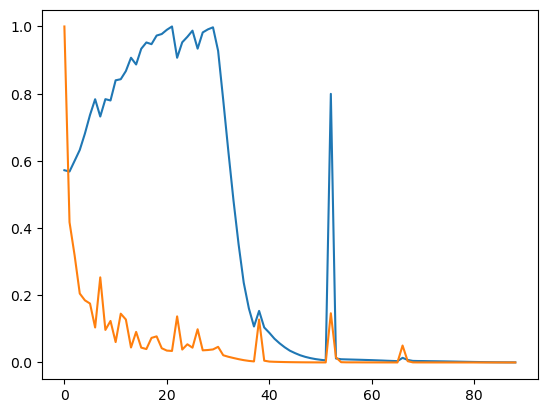

In [40]:
plt.figure()
plt.plot(np.array(loss_test)/max(loss_test))
plt.plot(np.array(loss_train)/max(loss_train))

In [41]:
torch.save(model, '../Models/model_main_another_bis')